In [1]:
import pandas as pd
df = pd.read_csv("EURUSD_Daily.csv")
df

,Gmt time,Open,High,Low,Close,Volume
0,01.01.2020 00:00:00.000,1.12120,1.12218,1.12106,1.12188,2621.3201
1,02.01.2020 00:00:00.000,1.12188,1.12245,1.11635,1.11708,487219.1250
2,03.01.2020 00:00:00.000,1.11707,1.11798,1.11249,1.11548,177406.7969
3,05.01.2020 00:00:00.000,1.11656,1.11677,1.11589,1.11604,4398.1001
4,06.01.2020 00:00:00.000,1.11603,1.12055,1.11571,1.11954,139965.2813
...,...,...,...,...,...,...
1268,22.01.2024 00:00:00.000,1.08920,1.09094,1.08768,1.08772,233830.1400
1269,23.01.2024 00:00:00.000,1.08776,1.09162,1.08215,1.08572,278337.1821
1270,24.01.2024 00:00:00.000,1.08573,1.09323,1.08514,1.08810,357244.5010
1271,25.01.2024 00:00:00.000,1.08811,1.09018,1.08216,1.08454,364079.3330


# Long Positions Volatility Related Labeling

In [50]:
import pandas_ta as ta
def atr_label_threshold_long(df, bars):
    df['ATR'] = ta.atr(df['High'], df['Low'], df['Close'])

    ratio = 1
    slcoef = 1
    tpcoef = ratio*slcoef

    lower_threshold_long = df['Close'] - df['ATR']*slcoef
    upper_threshold_long = df['Close'] + df['ATR']*tpcoef

    df = df.reset_index(drop=True)

    df['Label_Long'] = 0
    for i in range(len(df) - bars):   
       
        # Check if any future Close prices are above the upper threshold at the current index
        condition_1 = (df['Close'][i + 1:i + bars + 1] > upper_threshold_long.iloc[i]).any()
        # Ensure none of the future Close prices are below the lower threshold at the current index
        condition_2 = (df['Close'][i + 1:i + bars + 1] > lower_threshold_long.iloc[i]).all()

        # Set label based on conditions
        if condition_1 and condition_2:
            df.loc[i, 'Label_Long'] = 1

    return df

In [51]:
df = atr_label_threshold_long(df, 10)

In [52]:
import numpy as np
def pointpos(x, col):
    if x[col]==1:
        return x['Low']-1e-3
    elif x[col]==-1:
        return x['High']+1e-3
    else:
        return np.nan

df['pointpos'] = df.apply(lambda row: pointpos(row, "Label_Long"), axis=1)

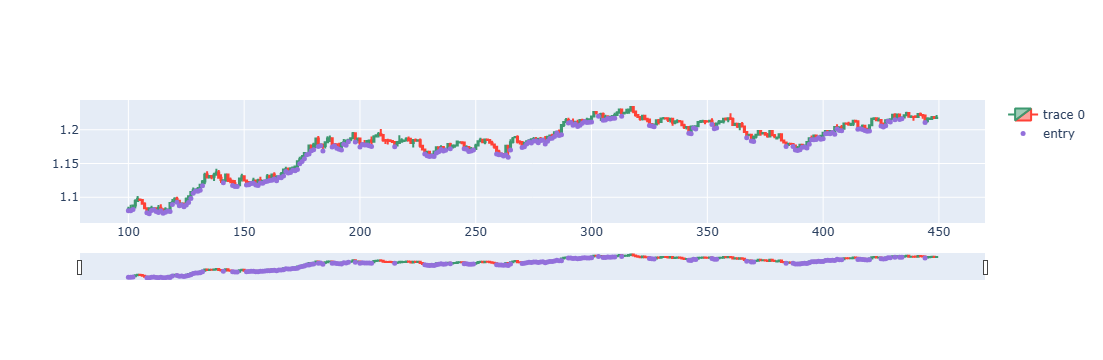

In [53]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime
st=100
dfpl = df[st:st+350]
#dfpl.reset_index(inplace=True)
fig = go.Figure(data=[go.Candlestick(x=dfpl.index,
                open=dfpl['Open'],
                high=dfpl['High'],
                low=dfpl['Low'],
                close=dfpl['Close'])])

fig.add_scatter(x=dfpl.index, y=dfpl['pointpos'], mode="markers",
                marker=dict(size=5, color="MediumPurple"),
                name="entry")

fig.show()

# Short Positions Volatility Related Labeling

In [54]:
def atr_label_threshold_short(df, bars):
    df['ATR'] = ta.atr(df['High'], df['Low'], df['Close'])

    ratio = 1
    slcoef = 1
    tpcoef = ratio*slcoef

    lower_threshold_short = df['Close'] - df['ATR']*tpcoef
    upper_threshold_short = df['Close'] + df['ATR']*slcoef

    df = df.reset_index(drop=True)

    # conditions for a short position where we're 
    # looking for the price to drop below a lower 
    # threshold without crossing an upper threshold in the future.

    df['Label_Short'] = 0
    for i in range(len(df) - bars):
        
        # Check if any future Close prices are below the lower threshold at the current index
        condition_1 = (df['Close'][i + 1:i + bars + 1] < lower_threshold_short.iloc[i]).any()
        
        # Ensure none of the future Close prices are above the upper threshold at the current index
        condition_2 = (df['Close'][i + 1:i + bars + 1] < upper_threshold_short.iloc[i]).all()
        
        # Set label based on conditions
        if condition_1 and condition_2:
            df.loc[i, 'Label_Short'] = -1

    return df

In [55]:
df = atr_label_threshold_short(df, 10)

In [56]:
df['pointpos'] = df.apply(lambda row: pointpos(row,"Label_Short"), axis=1)

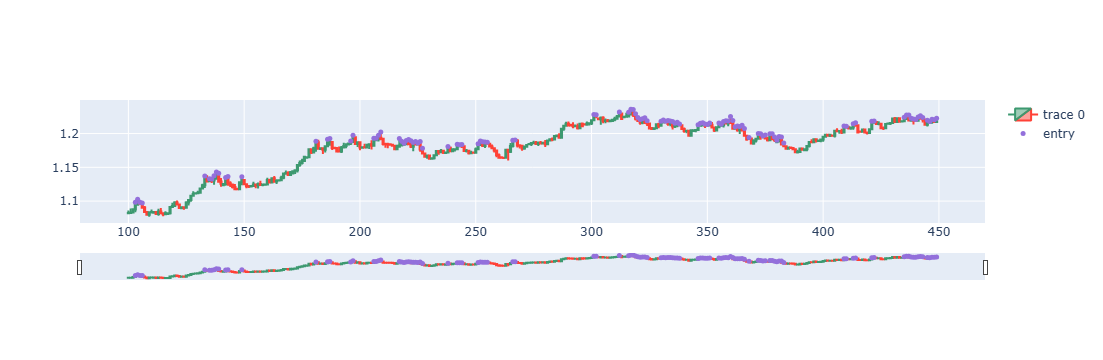

In [57]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime
st=100
dfpl = df[st:st+350]
#dfpl.reset_index(inplace=True)
fig = go.Figure(data=[go.Candlestick(x=dfpl.index,
                open=dfpl['Open'],
                high=dfpl['High'],
                low=dfpl['Low'],
                close=dfpl['Close'])])

fig.add_scatter(x=dfpl.index, y=dfpl['pointpos'], mode="markers",
                marker=dict(size=5, color="MediumPurple"),
                name="entry")

fig.show()

In [58]:
df["Label"] = df["Label_Long"] + df["Label_Short"]
df[df["Label"]!=0]

,Gmt time,Open,High,Low,Close,Volume,ATR,Label_Long,pointpos,Label_Short,Label,ema20,ema20_Slope,ema50,ema100,ema_Positions,Distance_to_ema20
14,17.01.2020 00:00:00.000,1.11368,1.11425,1.10862,1.10890,123846.6094,0.004300,0,1.11525,-1,-1,NaN,NaN,NaN,NaN,0,NaN
15,19.01.2020 00:00:00.000,1.10910,1.10948,1.10889,1.10946,3275.4700,0.003905,0,1.11048,-1,-1,NaN,NaN,NaN,NaN,0,NaN
16,20.01.2020 00:00:00.000,1.10946,1.11023,1.10766,1.10962,97595.1719,0.003768,0,1.11123,-1,-1,NaN,NaN,NaN,NaN,0,NaN
17,21.01.2020 00:00:00.000,1.10963,1.11179,1.10809,1.10851,133266.4375,0.003761,0,1.11279,-1,-1,NaN,NaN,NaN,NaN,0,NaN
18,22.01.2020 00:00:00.000,1.10851,1.10984,1.10700,1.10957,134188.8125,0.003672,0,1.11084,-1,-1,NaN,NaN,NaN,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1258,10.01.2024 00:00:00.000,1.09316,1.09747,1.09228,1.09740,257606.6520,0.005934,0,1.09847,-1,-1,1.095882,-0.000122,1.090167,1.084762,1,-0.001518
1259,11.01.2024 00:00:00.000,1.09742,1.10000,1.09302,1.09824,419645.9457,0.006009,0,1.10100,-1,-1,1.096107,-0.000009,1.090483,1.085029,1,-0.001313
1260,12.01.2024 00:00:00.000,1.09823,1.09868,1.09359,1.09483,308572.6066,0.005943,0,1.09968,-1,-1,1.095985,0.000037,1.090654,1.085223,1,0.001155
1261,14.01.2024 00:00:00.000,1.09480,1.09502,1.09440,1.09451,5573.3398,0.005563,0,1.09602,-1,-1,1.095845,0.000035,1.090805,1.085407,1,0.001045


In [59]:
df['pointpos'] = df.apply(lambda row: pointpos(row,"Label"), axis=1)

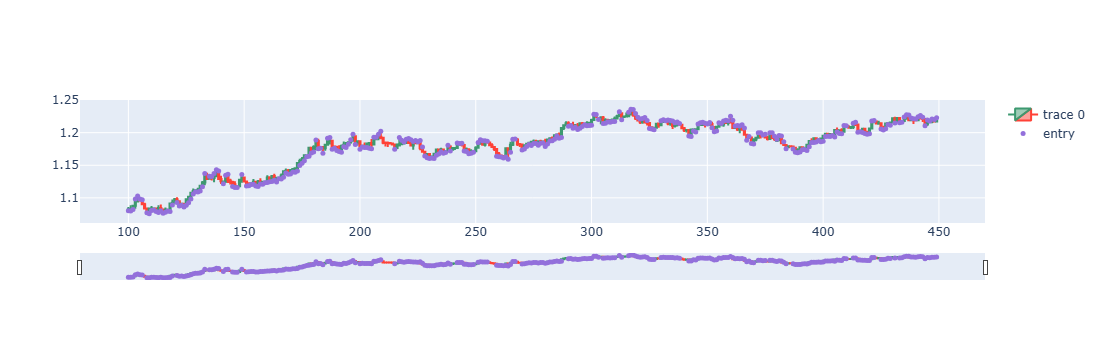

In [60]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime
st=100
dfpl = df[st:st+350]
#dfpl.reset_index(inplace=True)
fig = go.Figure(data=[go.Candlestick(x=dfpl.index,
                open=dfpl['Open'],
                high=dfpl['High'],
                low=dfpl['Low'],
                close=dfpl['Close'])])

fig.add_scatter(x=dfpl.index, y=dfpl['pointpos'], mode="markers",
                marker=dict(size=5, color="MediumPurple"),
                name="entry")

fig.show()

# ema and ema Slope

In [61]:
df["ema20"] = ta.ema(df['Close'], length=20)
df

,Gmt time,Open,High,Low,Close,Volume,ATR,Label_Long,pointpos,Label_Short,Label,ema20,ema20_Slope,ema50,ema100,ema_Positions,Distance_to_ema20
0,01.01.2020 00:00:00.000,1.12120,1.12218,1.12106,1.12188,2621.3201,NaN,0,NaN,0,0,NaN,NaN,NaN,NaN,0,NaN
1,02.01.2020 00:00:00.000,1.12188,1.12245,1.11635,1.11708,487219.1250,NaN,0,NaN,0,0,NaN,NaN,NaN,NaN,0,NaN
2,03.01.2020 00:00:00.000,1.11707,1.11798,1.11249,1.11548,177406.7969,NaN,0,NaN,0,0,NaN,NaN,NaN,NaN,0,NaN
3,05.01.2020 00:00:00.000,1.11656,1.11677,1.11589,1.11604,4398.1001,NaN,0,NaN,0,0,NaN,NaN,NaN,NaN,0,NaN
4,06.01.2020 00:00:00.000,1.11603,1.12055,1.11571,1.11954,139965.2813,NaN,0,NaN,0,0,NaN,NaN,NaN,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1268,22.01.2024 00:00:00.000,1.08920,1.09094,1.08768,1.08772,233830.1400,0.004945,0,NaN,0,0,1.092462,-0.000459,1.090427,1.085916,1,0.003262
1269,23.01.2024 00:00:00.000,1.08776,1.09162,1.08215,1.08572,278337.1821,0.005268,0,NaN,0,0,1.091820,-0.000476,1.090242,1.085912,1,0.004060
1270,24.01.2024 00:00:00.000,1.08573,1.09323,1.08514,1.08810,357244.5010,0.005470,0,NaN,0,0,1.091466,-0.000492,1.090158,1.085955,1,0.003366
1271,25.01.2024 00:00:00.000,1.08811,1.09018,1.08216,1.08454,364079.3330,0.005652,0,NaN,0,0,1.090806,-0.000531,1.089938,1.085927,1,0.002696


In [62]:
from scipy.stats import linregress

def compute_slope(window):
    # Use only the last 5 values of the window
    if len(window) < 5:
        return np.nan  # Not enough data to compute the slope
    y = window[-5:]
    x = np.arange(len(y))
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    return slope

# Apply the function to compute the slope of ema20
df['ema20_Slope'] = df['ema20'].rolling(window=5, min_periods=5).apply(compute_slope, raw=True)

In [63]:
df

,Gmt time,Open,High,Low,Close,Volume,ATR,Label_Long,pointpos,Label_Short,Label,ema20,ema20_Slope,ema50,ema100,ema_Positions,Distance_to_ema20
0,01.01.2020 00:00:00.000,1.12120,1.12218,1.12106,1.12188,2621.3201,NaN,0,NaN,0,0,NaN,NaN,NaN,NaN,0,NaN
1,02.01.2020 00:00:00.000,1.12188,1.12245,1.11635,1.11708,487219.1250,NaN,0,NaN,0,0,NaN,NaN,NaN,NaN,0,NaN
2,03.01.2020 00:00:00.000,1.11707,1.11798,1.11249,1.11548,177406.7969,NaN,0,NaN,0,0,NaN,NaN,NaN,NaN,0,NaN
3,05.01.2020 00:00:00.000,1.11656,1.11677,1.11589,1.11604,4398.1001,NaN,0,NaN,0,0,NaN,NaN,NaN,NaN,0,NaN
4,06.01.2020 00:00:00.000,1.11603,1.12055,1.11571,1.11954,139965.2813,NaN,0,NaN,0,0,NaN,NaN,NaN,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1268,22.01.2024 00:00:00.000,1.08920,1.09094,1.08768,1.08772,233830.1400,0.004945,0,NaN,0,0,1.092462,-0.000459,1.090427,1.085916,1,0.003262
1269,23.01.2024 00:00:00.000,1.08776,1.09162,1.08215,1.08572,278337.1821,0.005268,0,NaN,0,0,1.091820,-0.000476,1.090242,1.085912,1,0.004060
1270,24.01.2024 00:00:00.000,1.08573,1.09323,1.08514,1.08810,357244.5010,0.005470,0,NaN,0,0,1.091466,-0.000492,1.090158,1.085955,1,0.003366
1271,25.01.2024 00:00:00.000,1.08811,1.09018,1.08216,1.08454,364079.3330,0.005652,0,NaN,0,0,1.090806,-0.000531,1.089938,1.085927,1,0.002696


In [64]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime
st=100
dfpl = df[st:st+350]
#dfpl.reset_index(inplace=True)
fig = go.Figure(data=[go.Candlestick(x=dfpl.index,
                open=dfpl['Open'],
                high=dfpl['High'],
                low=dfpl['Low'],
                close=dfpl['Close'])])

# Add ema20 line
fig.add_trace(go.Scatter(x=dfpl.index, y=dfpl['ema20'], mode='lines',
                         line=dict(width=2, color='blue'), name='ema20',
                         hoverinfo='text',
                         text='ema20 Slope: ' + dfpl['ema20_Slope'].round(4).astype(str)))  # Round for better readability

# Add entry points as before
fig.add_scatter(x=dfpl.index, y=dfpl['pointpos'], mode="markers",
                marker=dict(size=5, color="MediumPurple"),
                name="entry")

fig.update_layout(
    title="Candlestick chart with ema20 and Slope Information",
    xaxis_title="Date",
    yaxis_title="Price",
    hovermode="x unified" 
)

# 3 Moving Averages

In [65]:
df['ema50'] = ta.ema(df['Close'], length=50)
df['ema100'] = ta.ema(df['Close'], length=100)

In [66]:
def ema_positions(row):
    if row['ema20'] > row['ema50'] > row['ema100']:
        return 1
    elif row['ema20'] < row['ema50'] < row['ema100']:
        return -1
    else:
        return 0

In [67]:
df['ema_Positions'] = df.apply(ema_positions, axis=1)

In [68]:
df

,Gmt time,Open,High,Low,Close,Volume,ATR,Label_Long,pointpos,Label_Short,Label,ema20,ema20_Slope,ema50,ema100,ema_Positions,Distance_to_ema20
0,01.01.2020 00:00:00.000,1.12120,1.12218,1.12106,1.12188,2621.3201,NaN,0,NaN,0,0,NaN,NaN,NaN,NaN,0,NaN
1,02.01.2020 00:00:00.000,1.12188,1.12245,1.11635,1.11708,487219.1250,NaN,0,NaN,0,0,NaN,NaN,NaN,NaN,0,NaN
2,03.01.2020 00:00:00.000,1.11707,1.11798,1.11249,1.11548,177406.7969,NaN,0,NaN,0,0,NaN,NaN,NaN,NaN,0,NaN
3,05.01.2020 00:00:00.000,1.11656,1.11677,1.11589,1.11604,4398.1001,NaN,0,NaN,0,0,NaN,NaN,NaN,NaN,0,NaN
4,06.01.2020 00:00:00.000,1.11603,1.12055,1.11571,1.11954,139965.2813,NaN,0,NaN,0,0,NaN,NaN,NaN,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1268,22.01.2024 00:00:00.000,1.08920,1.09094,1.08768,1.08772,233830.1400,0.004945,0,NaN,0,0,1.092462,-0.000459,1.090427,1.085916,1,0.003262
1269,23.01.2024 00:00:00.000,1.08776,1.09162,1.08215,1.08572,278337.1821,0.005268,0,NaN,0,0,1.091820,-0.000476,1.090242,1.085912,1,0.004060
1270,24.01.2024 00:00:00.000,1.08573,1.09323,1.08514,1.08810,357244.5010,0.005470,0,NaN,0,0,1.091466,-0.000492,1.090158,1.085955,1,0.003366
1271,25.01.2024 00:00:00.000,1.08811,1.09018,1.08216,1.08454,364079.3330,0.005652,0,NaN,0,0,1.090806,-0.000531,1.089938,1.085927,1,0.002696


In [69]:
import plotly.graph_objects as go
from datetime import datetime

st = 100
dfpl = df[st:st+350]

fig = go.Figure(data=[go.Candlestick(x=dfpl.index,
                                     open=dfpl['Open'],
                                     high=dfpl['High'],
                                     low=dfpl['Low'],
                                     close=dfpl['Close'],
                                     name="Candles")])

# Function to generate hover text for ema lines
def generate_hover_text(dfpl):
    return ('ema20: ' + dfpl['ema20'].round(4).astype(str) +
            '<br>ema50: ' + dfpl['ema50'].round(4).astype(str) +
            '<br>ema100: ' + dfpl['ema100'].round(4).astype(str) +
            '<br>ema Positions: ' + dfpl['ema_Positions'].astype(str))

hover_text = generate_hover_text(dfpl)

# Add ema20 line
fig.add_trace(go.Scatter(x=dfpl.index, y=dfpl['ema20'], mode='lines',
                         line=dict(width=2, color='blue'), name='ema20',
                         hoverinfo='text',
                         text=hover_text))

# Add ema50 line
fig.add_trace(go.Scatter(x=dfpl.index, y=dfpl['ema50'], mode='lines',
                         line=dict(width=2, color='green'), name='ema50',
                         hoverinfo='text',
                         text=hover_text))

# Add ema100 line
fig.add_trace(go.Scatter(x=dfpl.index, y=dfpl['ema100'], mode='lines',
                         line=dict(width=2, color='red'), name='ema100',
                         hoverinfo='text',
                         text=hover_text))

# Add entry points as before (assuming 'pointpos' exists in your df)
fig.add_scatter(x=dfpl.index, y=dfpl['pointpos'], mode="markers",
                marker=dict(size=5, color="MediumPurple"),
                name="entry")

fig.update_layout(
    title="Candlestick chart with emas and ema Positions Information",
    xaxis_title="Date",
    yaxis_title="Price",
    hovermode="x unified"  # Unified hover mode for better comparison
)

fig.show()


# Moving Average Distance

In [70]:
def compute_distance(row):
    # Determine the closest point to EMA20 (either Open or Close)
    closest_point = min(row['Open'], row['Close'], key=lambda x: abs(x - row['ema20']))
    # Compute the absolute distance between the closest point and EMA20
    distance = row['ema20'] - closest_point
    return distance

In [71]:
df['Distance_to_ema20'] = df.apply(compute_distance, axis=1)

In [72]:
df

,Gmt time,Open,High,Low,Close,Volume,ATR,Label_Long,pointpos,Label_Short,Label,ema20,ema20_Slope,ema50,ema100,ema_Positions,Distance_to_ema20
0,01.01.2020 00:00:00.000,1.12120,1.12218,1.12106,1.12188,2621.3201,NaN,0,NaN,0,0,NaN,NaN,NaN,NaN,0,NaN
1,02.01.2020 00:00:00.000,1.12188,1.12245,1.11635,1.11708,487219.1250,NaN,0,NaN,0,0,NaN,NaN,NaN,NaN,0,NaN
2,03.01.2020 00:00:00.000,1.11707,1.11798,1.11249,1.11548,177406.7969,NaN,0,NaN,0,0,NaN,NaN,NaN,NaN,0,NaN
3,05.01.2020 00:00:00.000,1.11656,1.11677,1.11589,1.11604,4398.1001,NaN,0,NaN,0,0,NaN,NaN,NaN,NaN,0,NaN
4,06.01.2020 00:00:00.000,1.11603,1.12055,1.11571,1.11954,139965.2813,NaN,0,NaN,0,0,NaN,NaN,NaN,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1268,22.01.2024 00:00:00.000,1.08920,1.09094,1.08768,1.08772,233830.1400,0.004945,0,NaN,0,0,1.092462,-0.000459,1.090427,1.085916,1,0.003262
1269,23.01.2024 00:00:00.000,1.08776,1.09162,1.08215,1.08572,278337.1821,0.005268,0,NaN,0,0,1.091820,-0.000476,1.090242,1.085912,1,0.004060
1270,24.01.2024 00:00:00.000,1.08573,1.09323,1.08514,1.08810,357244.5010,0.005470,0,NaN,0,0,1.091466,-0.000492,1.090158,1.085955,1,0.003366
1271,25.01.2024 00:00:00.000,1.08811,1.09018,1.08216,1.08454,364079.3330,0.005652,0,NaN,0,0,1.090806,-0.000531,1.089938,1.085927,1,0.002696


# Features Correlation 

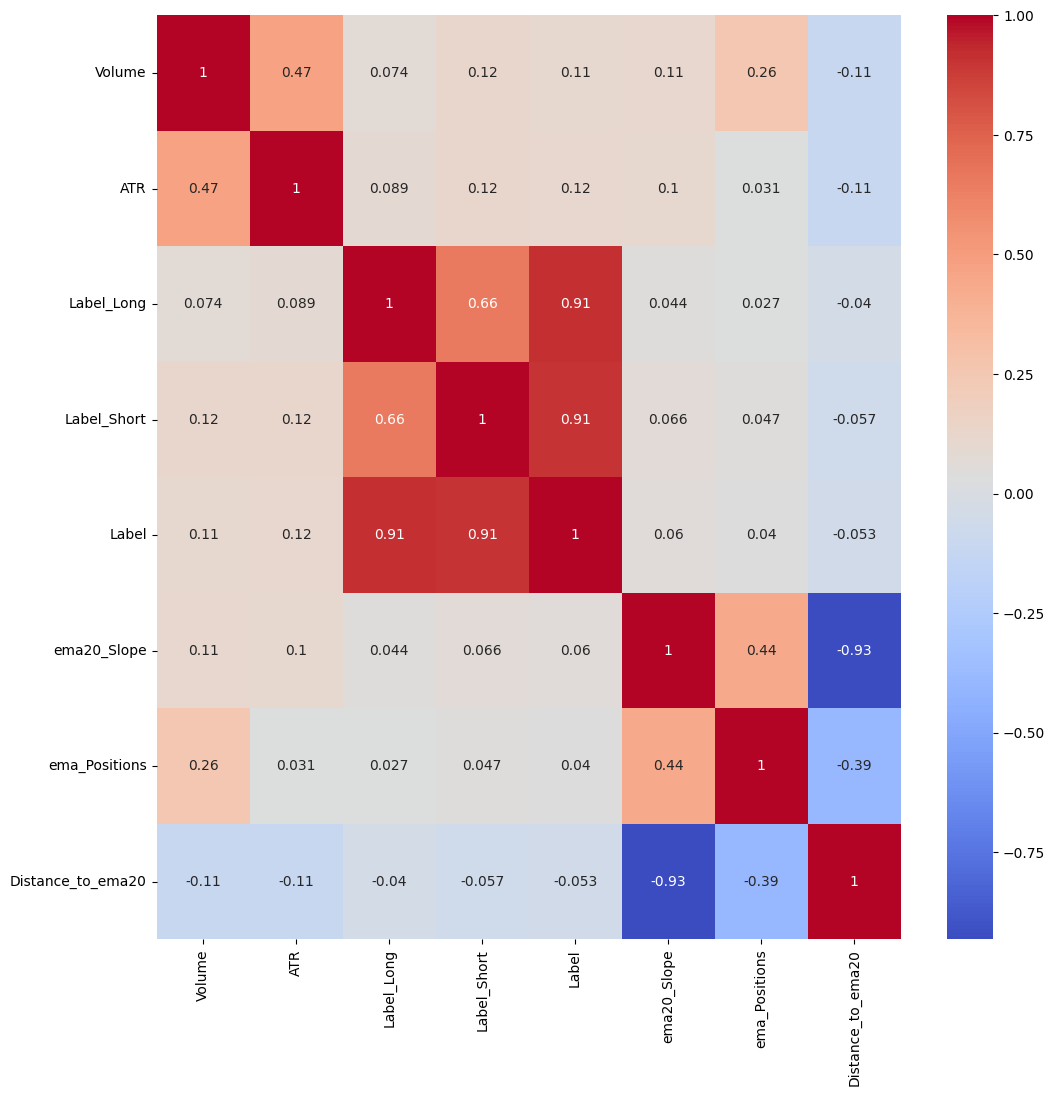

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculating Pearson correlation
corr_matrix = df.drop(["Gmt time", "Open", "High", "Low", "Close", "pointpos", "ema20", "ema50", "ema100"], axis = 1).corr(method='spearman')
plt.figure(figsize=(12, 12))
# Visualizing the correlation matrix
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

# Polynomial features enhancement And Preprocessing

In [74]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
import pandas as pd

df_analysis = df.loc[:, ["ATR", "Volume", "ema20_Slope", "ema_Positions"]].copy()
df_analysis = df_analysis.dropna()

# Creating an instance of PolynomialFeatures to include up to degree 3 interactions
poly = PolynomialFeatures(degree=3)

# Dropping 'ema_Positions' because it's a categorical feature we will hot encode it later
X = df_analysis.drop("ema_Positions", axis=1)

# Apply polynomial transformation
X_poly = poly.fit_transform(X)
feature_names = poly.get_feature_names_out(["ATR", "Volume", "ema20_Slope"])

# Since X_poly is a NumPy array, we convert it to DataFrame for easier manipulation
#X_poly_df = pd.DataFrame(X_poly, columns=feature_names)

# One Hot encoding
# Note: It's important to ensure that the index aligns between df_analysis and X_poly_df this is why we rest_index()
ema_Positions_encoded = pd.get_dummies(df_analysis['ema_Positions'], prefix='ema_Position').reset_index(drop=True)

# Before joining Categorical coded columns apply Standardization or Normalization
# Standardization
scaler = StandardScaler()
X_poly = scaler.fit_transform(X_poly)

# Alternatively, for normalization
# scaler = MinMaxScaler()
# X_poly = scaler.fit_transform(X_poly)

# Since X_poly is a NumPy array, we convert it to DataFrame for easier manipulation
X_poly_df = pd.DataFrame(X_poly, columns=feature_names)

# Join the one-hot encoded DataFrame with the polynomial features DataFrame
df_poly = X_poly_df.join(ema_Positions_encoded)

# Now df_poly contains polynomial features along with one-hot encoded 'ema_Positions'
df_poly.drop("1", axis=1, inplace=True)
df_poly

,ATR,Volume,ema20_Slope,ATR^2,ATR Volume,ATR ema20_Slope,Volume^2,Volume ema20_Slope,ema20_Slope^2,ATR^3,...,ATR Volume^2,ATR Volume ema20_Slope,ATR ema20_Slope^2,Volume^3,Volume^2 ema20_Slope,Volume ema20_Slope^2,ema20_Slope^3,ema_Position_-1,ema_Position_0,ema_Position_1
0,-1.847814,-0.526854,-0.867275,-1.323941,-0.723584,-0.377240,-0.432840,-0.350153,-0.142293,-0.941536,...,-0.477445,-0.159919,-0.337142,-0.298214,-0.096645,-0.259015,-0.167286,False,True,False
1,-1.851110,-0.526970,-0.801946,-1.325391,-0.724010,-0.348574,-0.432869,-0.327867,-0.214369,-0.942115,...,-0.477510,-0.151445,-0.363103,-0.298219,-0.092682,-0.278557,-0.135142,False,True,False
2,-1.867058,-0.439782,-0.721625,-1.332370,-0.689816,-0.311483,-0.409524,-0.342503,-0.295401,-0.944889,...,-0.467105,-0.155969,-0.392994,-0.294004,-0.103959,-0.284518,-0.102083,False,True,False
3,-1.677422,-0.449213,-0.501609,-1.245577,-0.668790,-0.240114,-0.412222,-0.251981,-0.474530,-0.908787,...,-0.464427,-0.130126,-0.450026,-0.294524,-0.084578,-0.341967,-0.042557,False,True,False
4,-1.791531,-1.030789,-0.247220,-1.298799,-0.933664,-0.114295,-0.497238,-0.052619,-0.603408,-0.931336,...,-0.507134,-0.049215,-0.501043,-0.305362,-0.043359,-0.395649,-0.015245,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1245,-1.138523,-0.055818,-0.443775,-0.953527,-0.372613,-0.269005,-0.263863,-0.347404,-0.511199,-0.764421,...,-0.359429,-0.200209,-0.450415,-0.256109,-0.143845,-0.325353,-0.033152,False,False,True
1246,-0.967787,0.133141,-0.461301,-0.846986,-0.220128,-0.297740,-0.166536,-0.417599,-0.500544,-0.704026,...,-0.284155,-0.248360,-0.440472,-0.222292,-0.191170,-0.305359,-0.035769,False,False,True
1247,-0.861320,0.468149,-0.477731,-0.777136,0.019730,-0.319929,0.047596,-0.538184,-0.490195,-0.662405,...,-0.125730,-0.324166,-0.431921,-0.129720,-0.295245,-0.271498,-0.038404,False,False,True
1248,-0.765098,0.497167,-0.516103,-0.711753,0.070730,-0.356511,0.068646,-0.586207,-0.464660,-0.622055,...,-0.097803,-0.361402,-0.414788,-0.119444,-0.325297,-0.248629,-0.045272,False,False,True


In [75]:
X_poly_df

,1,ATR,Volume,ema20_Slope,ATR^2,ATR Volume,ATR ema20_Slope,Volume^2,Volume ema20_Slope,ema20_Slope^2,ATR^3,ATR^2 Volume,ATR^2 ema20_Slope,ATR Volume^2,ATR Volume ema20_Slope,ATR ema20_Slope^2,Volume^3,Volume^2 ema20_Slope,Volume ema20_Slope^2,ema20_Slope^3
0,0.0,-1.847814,-0.526854,-0.867275,-1.323941,-0.723584,-0.377240,-0.432840,-0.350153,-0.142293,-0.941536,-0.706298,-0.138021,-0.477445,-0.159919,-0.337142,-0.298214,-0.096645,-0.259015,-0.167286
1,0.0,-1.851110,-0.526970,-0.801946,-1.325391,-0.724010,-0.348574,-0.432869,-0.327867,-0.214369,-0.942115,-0.706591,-0.127222,-0.477510,-0.151445,-0.363103,-0.298219,-0.092682,-0.278557,-0.135142
2,0.0,-1.867058,-0.439782,-0.721625,-1.332370,-0.689816,-0.311483,-0.409524,-0.342503,-0.295401,-0.944889,-0.694868,-0.112593,-0.467105,-0.155969,-0.392994,-0.294004,-0.103959,-0.284518,-0.102083
3,0.0,-1.677422,-0.449213,-0.501609,-1.245577,-0.668790,-0.240114,-0.412222,-0.251981,-0.474530,-0.908787,-0.677309,-0.095439,-0.464427,-0.130126,-0.450026,-0.294524,-0.084578,-0.341967,-0.042557
4,0.0,-1.791531,-1.030789,-0.247220,-1.298799,-0.933664,-0.114295,-0.497238,-0.052619,-0.603408,-0.931336,-0.783116,-0.042292,-0.507134,-0.049215,-0.501043,-0.305362,-0.043359,-0.395649,-0.015245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1245,0.0,-1.138523,-0.055818,-0.443775,-0.953527,-0.372613,-0.269005,-0.263863,-0.347404,-0.511199,-0.764421,-0.500238,-0.135385,-0.359429,-0.200209,-0.450415,-0.256109,-0.143845,-0.325353,-0.033152
1246,0.0,-0.967787,0.133141,-0.461301,-0.846986,-0.220128,-0.297740,-0.166536,-0.417599,-0.500544,-0.704026,-0.399934,-0.159864,-0.284155,-0.248360,-0.440472,-0.222292,-0.191170,-0.305359,-0.035769
1247,0.0,-0.861320,0.468149,-0.477731,-0.777136,0.019730,-0.319929,0.047596,-0.538184,-0.490195,-0.662405,-0.251852,-0.178483,-0.125730,-0.324166,-0.431921,-0.129720,-0.295245,-0.271498,-0.038404
1248,0.0,-0.765098,0.497167,-0.516103,-0.711753,0.070730,-0.356511,0.068646,-0.586207,-0.464660,-0.622055,-0.204776,-0.205665,-0.097803,-0.361402,-0.414788,-0.119444,-0.325297,-0.248629,-0.045272


# Principal Components

In [76]:
from sklearn.decomposition import PCA

# Creating a PCA instance: PCA for 2 components
pca = PCA(n_components=3)

# Fit and transform the data
principalComponents = pca.fit_transform(df_poly.drop(["ema_Position_-1",	"ema_Position_0", "ema_Position_1"], axis=1))

In [77]:
principalComponents

array([[-2.45173303, -0.24089447, -0.79747404],
       [-2.44823449, -0.30766682, -0.84138843],
       [-2.40111334, -0.34356171, -0.93675102],
       ...,
       [-1.0931346 ,  0.37725202, -1.17017193],
       [-1.00636807,  0.50955387, -1.1275458 ],
       [-1.27121766,  0.32354723, -0.81998905]])

In [78]:
# Creating a DataFrame with the principal components
df_pca = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2', "PC3"])

df_pca[["ema_Position_-1",	"ema_Position_0", "ema_Position_1"]] = df_poly[["ema_Position_-1",	"ema_Position_0", "ema_Position_1"]]

# Adding back the 'Label' column to the PCA DataFrame
df_pca['Label'] = df.Label

In [79]:
df_pca

,PC1,PC2,PC3,ema_Position_-1,ema_Position_0,ema_Position_1,Label
0,-2.451733,-0.240894,-0.797474,False,True,False,0
1,-2.448234,-0.307667,-0.841388,False,True,False,0
2,-2.401113,-0.343562,-0.936751,False,True,False,0
3,-2.290479,-0.488740,-0.949804,False,True,False,0
4,-2.603093,-0.935473,-0.843441,False,True,False,0
...,...,...,...,...,...,...,...
1245,-1.725052,-0.136492,-0.928998,False,False,True,0
1246,-1.468584,0.074557,-0.963151,False,False,True,0
1247,-1.093135,0.377252,-1.170172,False,False,True,-1
1248,-1.006368,0.509554,-1.127546,False,False,True,-1


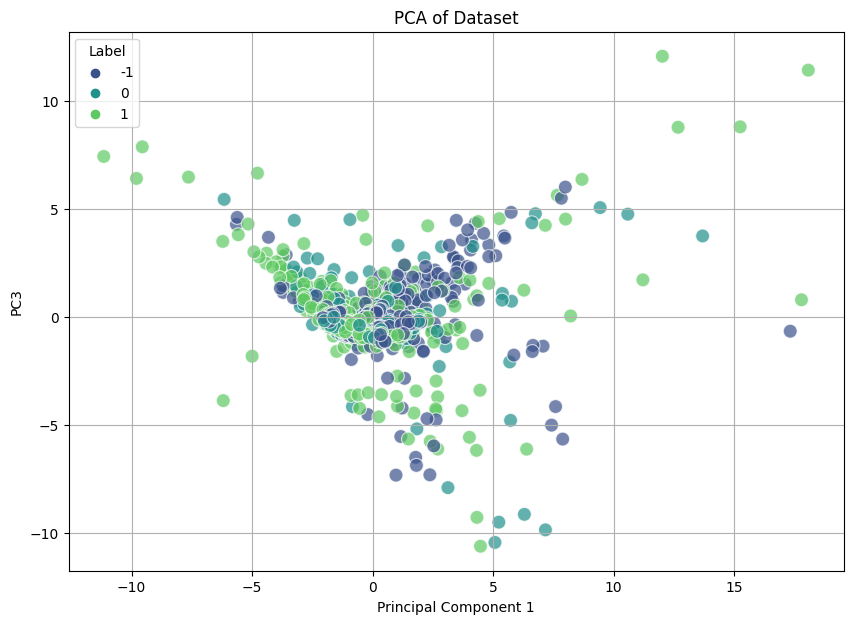

In [80]:
df_pca['Label'] = df_pca['Label'].astype('category')

# Plotting
plt.figure(figsize=(10, 7))
sns.scatterplot(x='PC2', y='PC3', hue='Label', data=df_pca, palette='viridis', s=100, alpha=0.7).set(title='PCA of Dataset')

# Enhancing the plot
plt.xlabel('Principal Component 1')
#plt.ylabel('Principal Component 2')
plt.ylabel('PC3')
plt.legend(title='Label', loc='best')
plt.grid(True)
plt.show()

# Training Machine Learning Model

In [81]:
df_pca["Label"] = df_pca["Label"].replace(-1, 0)

In [82]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [83]:
# Splitting the dataset into training and testing sets
X = df_pca.drop(['Label'], axis=1)
y = df_pca['Label']


# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#------------------------------------------------------------------------------------
# Define the split point
split_ratio = 0.7  # For example, 80% for training and 20% for testing
split_point = int(len(df_pca) * split_ratio)

# Splitting the dataset into training and testing sets sequentially
X_train = X.iloc[:split_point]
y_train = y.iloc[:split_point]
X_test = X.iloc[split_point:]
y_test = y.iloc[split_point:]

### Log Regression

In [90]:
# The Log Regression Model
clf = LogisticRegression()
# Training the Logistic Regression classifier
clf.fit(X_train, y_train)
# Predicting the test set results
#y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class

# Setting a custom threshold for classification
threshold = 0.4  # Customize this value
y_pred = (y_pred_proba >= threshold).astype(int)

### SVC

Note that training SVC models with probability=True can be slower because it internally uses cross-validation to estimate class probabilities.

In [85]:
clf = SVC(kernel='rbf', gamma=0.2, probability=True, random_state=42)
clf.fit(X_train, y_train)

# Predicting the test set results
#y_pred = clf.predict(X_test)

y_pred_proba = clf.predict_proba(X_test)[:, 1] 
threshold = 0.4  # Customize this value
y_pred = (y_pred_proba >= threshold).astype(int)


### Random Forests

In [48]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train the classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict on the test set
# y_pred = clf.predict(X_test)

y_pred_proba = clf.predict_proba(X_test)[:, 1]
threshold = 0.4  # Customize this value
y_pred = (y_pred_proba >= threshold).astype(int)

### XGBoost

In [79]:
import xgboost as xgb

clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
clf.fit(X_train, y_train)

# Predict on the test set
# y_pred = clf.predict(X_test)

y_pred_proba = clf.predict_proba(X_test)[:, 1]
threshold = 0.3  # Customize this value
y_pred = (y_pred_proba >= threshold).astype(int)

### Neural Networks Classifier

In [129]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(hidden_layer_sizes=(50, 100, 100, 100, 10), activation='relu', solver='adam', max_iter=5000, random_state=42)
clf.fit(X_train, y_train)
y_pred_proba = clf.predict_proba(X_test)[:, 1]
threshold = 0.45  # Customize this value
y_pred = (y_pred_proba >= threshold).astype(int)

### Evaluating Classifiers

Accuracy Score: 0.6933333333333334
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.55      0.66       207
           1       0.61      0.88      0.72       168

    accuracy                           0.69       375
   macro avg       0.73      0.71      0.69       375
weighted avg       0.74      0.69      0.69       375



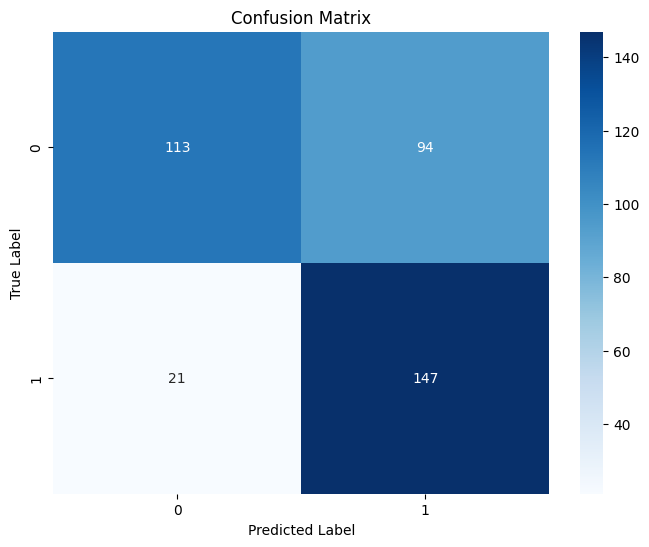

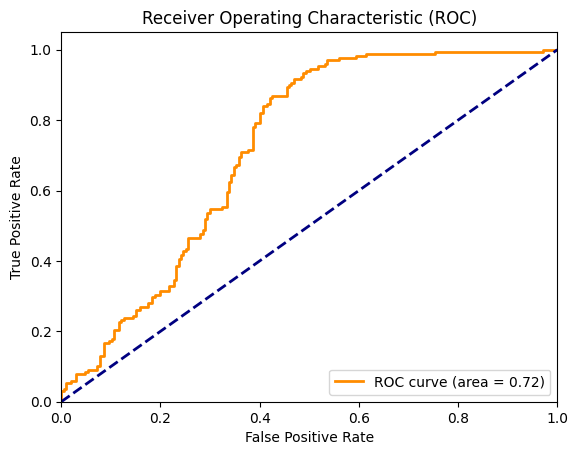

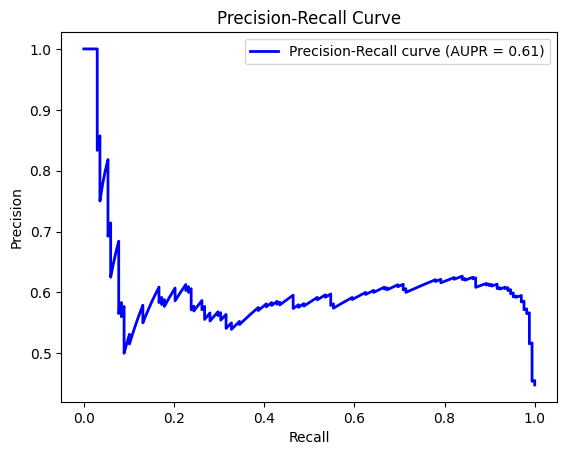

In [91]:
# Evaluating the classifier
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix Heatmap
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve and AUPR
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
aupr = average_precision_score(y_test, y_pred_proba)

plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (AUPR = %0.2f)' % aupr)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()
